# Decoding the AI Revolution: A Journey Through the Hugging Face Hub

Artificial intelligence is everywhere, changing our world quickly. Behind the headlines, there’s a large, open community of creators and developers working together. This led me to the Hugging Face Hub, a busy digital town square for the AI world. With thousands of models appearing constantly, a big question arose: how do you tell the real breakthroughs from the background noise?

I was curious not just about the technology but also about the human aspect of this revolution. What makes one AI model a "superstar" with millions of downloads while another stays a niche experiment? Which new ideas are gaining traction, and who are the key players shaping the future? I felt like an explorer trying to map a new and rapidly growing land.

To understand this, I explored the Hugging Face API, which offered a treasure trove of live data—model types, download stats, community likes, and programming frameworks, all waiting to share their story. 

My goal was to turn this raw data into a clear picture. For developers, this analysis could serve as a guide to what the community values most. For enthusiasts, it could provide a real glimpse into the trends driving our AI-powered future. Ultimately, this project is my attempt to decode the very essence of the open-source AI movement.

# Research question

1. RQ1: How do model age and the timing of updates influence adoption?
    - tested this using 30-day and 90-day recency indicators, cohort analysis, and age effects in regression.

2. RQ2: To what extent does author reputation drive popularity?
    -  measured this through total author downloads, the number of models published, and correlation with model success. 

3. RQ3: Do user engagement signals, like likes, translate into downloads?
    -  explored this with like rate correlations and regression coefficients. 

4. RQ4: How do categories, like pipelines, and frameworks, like libraries, affect model visibility?
    -  assessed this through median DPM comparisons and regression coefficients for each pipeline and library. 

5. RQ5: Are popularity patterns stable across cohorts or driven by outliers?
    - validated this with cohort median DPM trends, the exclusion of the top 1% of downloads, and checks for pipeline stability.
      
6. RQ6: Which factors are the strongest predictors of model popularity?
    - addressed this through baseline regression, comparisons of multiple models (OLS, Ridge, Lasso, ElasticNet, RandomForest), and rankings of feature importance.

## Here are some Python packages that we used for this analysis:

- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical operations.
- `matplotlib`: For creating static, animated, and interactive visualizations.
- `seaborn`: For statistical data visualization.
- `scikit-learn`: For any machine learning tasks or advanced analysis.
- `plotly.express`: For working with Column-oriented, Matrix or Geographic Data(mostly for visualization).
- `huggingface_hub`: For accessing and sharing pre-trained models, datasets, and other machine learning resources from the Hugging Face Hub. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

## API-Based Dataset retrievel

We are getting metadata for the top 10,000 most downloaded AI models from the Hugging Face Hub through its API. For each model, we gather details such as model ID, author, download count, likes, tags, task type, library used, license, creation dates, and an estimated parameter size (e.g., 7B, 125M) taken from the tags or model name. This information is organized into a structured dataset and saved as a CSV file for further analysis.

from huggingface_hub import HfApi
import pandas as pd
import re

api = HfApi()

LIMIT = 10000

def extract_parameters(tags, model_id):
    # Look for patterns like '7B', '125M', '34B' in tags
    if tags:
        for tag in tags.split(","):
            if re.fullmatch(r"\d+[BM]", tag.strip(), re.IGNORECASE):
                return tag.strip()
    # Fallback: Look for "<digits>B" or "<digits>M" in model_id (e.g. llama-3-70B, gpt-neo-125M)
    match = re.search(r'(\d+[BM])', model_id, re.IGNORECASE)
    if match:
        return match.group(1)
    return "Unknown"

models = api.list_models(
    limit=LIMIT,
    full=True,
    sort="downloads",
    direction=-1
)

data = []
for m in models:
    model_id_val = getattr(m, "modelId", getattr(m, "id", ""))
    tags_joined = ",".join(m.tags) if hasattr(m, "tags") and m.tags else ""
    parameters = extract_parameters(tags_joined, model_id_val)
    entry = {
        "model_id": model_id_val,
        "author": getattr(m, "author", ""),
        "downloads": getattr(m, "downloads", 0),
        "likes": getattr(m, "likes", 0),
        "tags": tags_joined,
        "pipeline_tag": getattr(m, "pipeline_tag", ""),
        "library": getattr(m, "library_name", ""),
        "created_at": str(getattr(m, "created_at", "")),
        "last_modified": str(getattr(m, "last_modified", "")),
        "license": getattr(m, "license", ""),
        "parameters": parameters  # New column
    }
    data.append(entry)

df = pd.DataFrame(data)
df = df.fillna("Unknown")
df.to_csv("huggingface_ai_models_10000_with_parameters1.csv", index=False)
print(f"Saved {len(df)} model entries to huggingface_ai_models_10000_with_parameters1.csv")

# Analysis Plan

To analyze the `huggingface_ai_models_10000_with_parameters1.csv` dataset, we will structure the workflow around our research questions.

# 1. Exploring the Dataset

## 1.1 Loading the dataset from huggingface_ai_models_10000_with_parameters1.csv file 

- In the initial step, we loaded the dataset from a `huggingface_ai_models_10000_with_parameters1.csv` file into a pandas DataFrame variable named **dataset** using the read_csv() function, enabling seamless data manipulation and analysis.
- Using the **head()** function, we inspected a small sample of the dataset, displaying the first few rows along with all column names. 

In [10]:
df = pd.read_csv('huggingface_ai_models_10000_with_parameters1.csv')
#allows the display of all columns in a dataframe without truncation
pd.set_option('display.max_columns',None) 
df.head(3)

,model_id,author,downloads,likes,tags,pipeline_tag,library,created_at,last_modified,license,parameters
0,timm/mobilenetv3_small_100.lamb_in1k,timm,108296563,33,"timm,pytorch,safetensors,image-classification,...",image-classification,timm,2022-12-16 05:38:36+00:00,2025-01-21 18:21:16+00:00,NaN,Unknown
1,Falconsai/nsfw_image_detection,Falconsai,106293179,809,"transformers,pytorch,safetensors,vit,image-cla...",image-classification,transformers,2023-10-13 23:50:01+00:00,2025-04-06 13:42:07+00:00,NaN,Unknown
2,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers,90715937,3836,"sentence-transformers,pytorch,tf,rust,onnx,saf...",sentence-similarity,sentence-transformers,2022-03-02 23:29:05+00:00,2025-03-06 13:37:44+00:00,NaN,Unknown


## 1.2 Dataset Overview Using .info() Function

- The **.info()** output summarizes the Hugging Face models dataset.

1. **Shape**: 10,000 entries and 11 columns.

2. **Data Types**: int64 for numerical counts such as downloads and likes; object for text or categorical fields like model_id, author, and tags.

3. **Missing Data**: Some columns, such as license, have many "Unknown" values because of missing information on the Hub.

4. **Memory Usage**: Around 0.9 MB.

This provides a quick look at the dataset’s structure and points out areas that need cleaning.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model_id       10000 non-null  object 
 1   author         10000 non-null  object 
 2   downloads      10000 non-null  int64  
 3   likes          10000 non-null  int64  
 4   tags           10000 non-null  object 
 5   pipeline_tag   10000 non-null  object 
 6   library        10000 non-null  object 
 7   created_at     10000 non-null  object 
 8   last_modified  10000 non-null  object 
 9   license        0 non-null      float64
 10  parameters     10000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 859.5+ KB


## 1.3 Dataset Overview Using .describe() Function

- The **.describe()** function provides a statistical summary of the numerical columns in the dataset. Here's a brief explanation of the output:

    1. **count**: The number of non-null entries for each column.
    2. **mean**: The average value of each column.
    3. **std**: The standard deviation, showing how spread out the values are.
    4. **min**: The minimum value in each column.
    5. **25%, 50%, 75%**: These are the 1st quartile (25%), median (50%), and 3rd quartile (75%), showing the distribution of values.
    6. **max**: The maximum value in each column.

In [14]:
df.describe()

,downloads,likes,license
count,1.000000e+04,10000.000000,0.0
mean,1.721657e+05,87.255800,NaN
std,2.128399e+06,351.265463,NaN
min,2.285000e+03,0.000000,NaN
25%,3.768750e+03,1.000000,NaN
50%,8.881500e+03,10.000000,NaN
75%,3.067700e+04,48.000000,NaN
max,1.082966e+08,12682.000000,NaN


## 1.4 Visualizing Missing Data with a Heatmap

The heatmap reveals that all columns are fully populated except for license, which has many missing entries (filled as "Unknown").

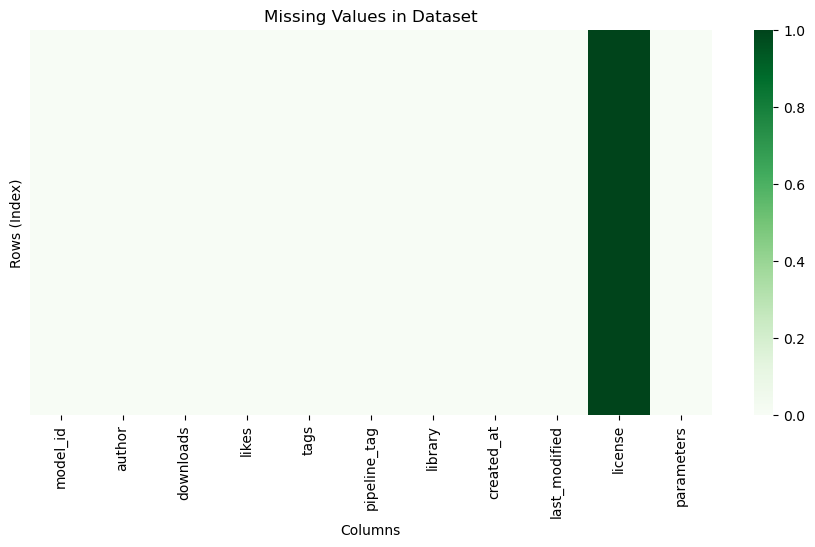

In [16]:
plt.figure(figsize=(11, 5))

# Generate heatmap for missing values, showing columns on x-axis and row indices on y-axis
sns.heatmap(df.isna(), cmap='Greens', cbar=True, xticklabels=True, yticklabels=False)

# Add titles and labels
plt.title('Missing Values in Dataset')
plt.xlabel('Columns')
plt.ylabel('Rows (Index)')
plt.show()

## 1.5 Detecting and Summarizing Missing Values Using .isna() and .sum() Functions  

We used the .isna() function to check for missing values in each column. We then counted them with .sum(). The results show that all columns are complete except for the license column, which has many missing entries. We will later replace these with "Unknown." This supports what we saw in the heatmap, which indicated that the missing data is mainly in one column. This makes it easy to handle during data cleaning.

In [18]:
print(df.isna().sum())

model_id             0
author               0
downloads            0
likes                0
tags                 0
pipeline_tag         0
library              0
created_at           0
last_modified        0
license          10000
parameters           0
dtype: int64


# 2. DATA CLEANING

## 2.1 Handling Missing Values in the `license` Column

We first dealt with the missing values in the `license` column, which was almost completely empty. At first, we replaced all the missing entries with `"Unknown"` for consistency.

After this step, we tried to improve the `license` column by getting license details from the Hugging Face Hub API for each model in the dataset.

However, the enrichment attempt did not yield results. We queried the Hugging Face Hub API for license details, but most models did not have this information in their metadata. As a result, the missing values are recorded as "Unknown." This keeps things consistent while showing that the license data is not available.

In [21]:
df.fillna({"license": "Unknown"}, inplace=True)

In [22]:
def fetch_license(model_id):
    try:
        model_info = api.model_info(model_id)
        if model_info.license:
            return model_info.license
        elif hasattr(model_info, "cardData") and model_info.cardData:
            return model_info.cardData.get("license", "Unknown")
        else:
            return "Unknown"
    except:
        return "Unknown"
test_models = df['model_id'].head(30)
for model in test_models:
    print(model, fetch_license(model))

timm/mobilenetv3_small_100.lamb_in1k Unknown
Falconsai/nsfw_image_detection Unknown
sentence-transformers/all-MiniLM-L6-v2 Unknown
dima806/fairface_age_image_detection Unknown
google-bert/bert-base-uncased Unknown
amazon/chronos-t5-small Unknown
tech4humans/yolov8s-signature-detector Unknown
pyannote/wespeaker-voxceleb-resnet34-LM Unknown
pyannote/segmentation-3.0 Unknown
pyannote/speaker-diarization-3.1 Unknown
sentence-transformers/all-mpnet-base-v2 Unknown
openai/clip-vit-base-patch32 Unknown
Bingsu/adetailer Unknown
google/t5gemma-b-b-prefixlm Unknown
context-labs/meta-llama-Llama-3.2-3B-Instruct-FP16 Unknown
Qwen/Qwen2.5-7B-Instruct Unknown
distilbert/distilbert-base-uncased Unknown
google/electra-base-discriminator Unknown
FacebookAI/roberta-base Unknown
openai-community/gpt2 Unknown
FacebookAI/roberta-large Unknown
sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 Unknown
prajjwal1/bert-tiny Unknown
facebook/opt-125m Unknown
timm/resnet50.a1_in1k Unknown
openai/gpt-oss

## 2.2 Converting the columns to the appropriate data type

Converted created_at and last_modified columns to timezone-naive datetime format for consistency in analysis.

In [24]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['last_modified'] = pd.to_datetime(df['last_modified'])
df['created_at'] = df['created_at'].dt.tz_localize(None)
df['last_modified'] = df['last_modified'].dt.tz_localize(None)

In [25]:
#checking unique values of a categorical column
df['pipeline_tag'].unique()

array(['image-classification', 'sentence-similarity', 'fill-mask',
       'time-series-forecasting', 'object-detection', 'Unknown',
       'voice-activity-detection', 'automatic-speech-recognition',
       'zero-shot-image-classification', 'text-generation',
       'feature-extraction', 'image-feature-extraction',
       'zero-shot-classification', 'text-to-speech', 'text-ranking',
       'image-text-to-text', 'audio-classification', 'summarization',
       'text-classification', 'depth-estimation', 'translation',
       'text-to-image', 'image-segmentation', 'keypoint-detection',
       'image-to-text', 'token-classification', 'image-to-3d',
       'text-to-audio', 'zero-shot-object-detection',
       'tabular-regression', 'audio-to-audio', 'question-answering',
       'visual-question-answering', 'image-to-image', 'image-to-video',
       'audio-text-to-text', 'any-to-any', 'video-classification',
       'mask-generation', 'text-to-video', 'tabular-classification',
       'document-q

In [26]:
# ensure last_modified >= created_at
df = df[df["last_modified"] >= df["created_at"]]

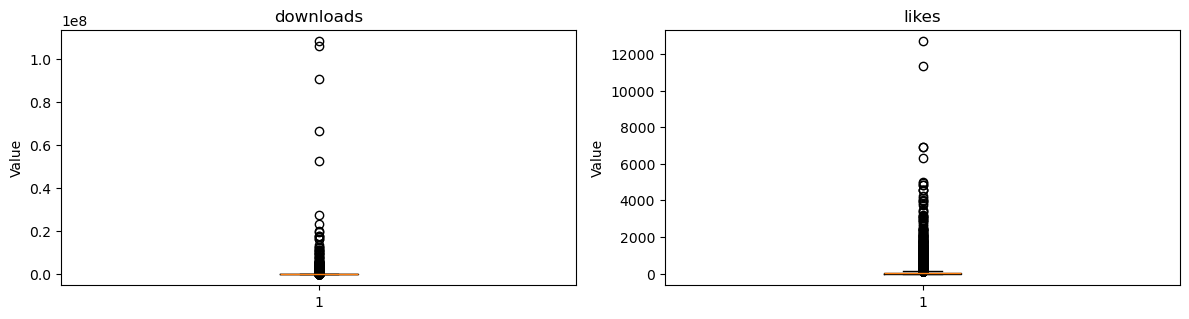

In [27]:
# checking outliers 
plt.figure(figsize=(12, 6))

columns_to_plot = ['downloads', 'likes']

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid for the subplots
    plt.boxplot(df[column])  
    plt.title(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

# 3.Descriptive Statistics & Feature Engineering  
In this stage, we conduct a thorough statistical analysis to understand the dataset's structure, trends, and patterns. We start with basic descriptive statistics like count, mean, median, and standard deviation for numeric fields, and frequency counts for categorical fields. This helps identify the general distribution of the data, common categories, and potential anomalies.  

Next, we perform statistical analysis, including correlation analysis to explore relationships between numeric variables, outlier detection to find unusual data points, and group-based aggregations to reveal trends within categories.  

After that, we carry out feature engineering to gain more insights. Specifically, we create three new columns:  

- **creation_year**: extracted from the created_at timestamp to determine the year each model was created.  
- **model_age**: calculated as the difference between the current year and creation_year to measure how old each model is.  
- **tags_list**: generated by splitting the tags column into individual elements, which allows for multi-tag analysis and frequency counts.  

Finally, we re-run descriptive statistics and visualizations that include these new features. This ensures they are part of the overall analysis and help reveal deeper trends in the dataset.  nalysis.

# 3.1 Feature Engineering  
In this stage, we create additional fields to capture model age, update recency, popularity adjusted for exposure time, author-level totals, and baseline performance by pipeline and library. These features allow for fairer comparisons across models with different lifespans, activity levels, authors, and categories. They also provide stronger signals for later analysis

## i) Age and Recency Features  
- **age_days** and **age_months** are calculated from `created_at` relative to the current date.  
- **recent_30d** and **recent_90d** are boolean flags that show whether the model has been updated in the last 30 or 90 days, based on `last_modified`


   
*Age features calculate how many days and months old each model is since its creation.*  
*Recency flags create markers to indicate if a model was updated in the last 30 or 90 days.*  .ctively.

In [30]:
# Age features 
today = pd.Timestamp.now()
df["age_days"] = (today - df["created_at"]).dt.days
df["age_months"] = df["age_days"] // 30
df["days_since_update"] = (today - df["last_modified"]).dt.days

# Recency flags 
df["recent_30d"] = (today - df["last_modified"]).dt.days <= 30
df["recent_90d"] = (today - df["last_modified"]).dt.days <= 90

## ii) Popularity Metrics  
- **DPM** (downloads per month) adjusts downloads based on model age.  
- **log_dpm** is the log-scaled version of DPM for normalization.  
- **like_rate** tracks likes per download to gauge engagement.  
*Popularity metrics measure downloads per month (DPM), log-scaled popularity, and the ratio of likes to downloads.* 

In [32]:
df["DPM"] = df["downloads"] / df["age_months"].replace(0, 1)
df["log_dpm"] = np.log1p(df["DPM"])
df["like_rate"] = df["likes"] / df["downloads"].replace(0, 1)

## iii) Author Aggregates  
- This aggregates downloads at the author level, including:  
  - **author_model_count** (number of models created by the author)  
  - **author_total_downloads** (total downloads across all models)  
  - **author_avg_downloads** (average downloads per model)  
*Author aggregates summarize how many models each author has and their total and average downloads.*  

In [34]:
author_grp = df.groupby("author").agg(author_model_count=("model_id", "count"),
    author_total_downloads=("downloads", "sum"),
    author_avg_downloads=("downloads", "mean")
).reset_index()

df = df.merge(author_grp, on="author", how="left")

## iv) Category Baselines  
- For each *`pipeline_tag`*, we calculate the median DPM (**pipeline_median_dpm**).  
- For each *`library`*, we calculate the median DPM (**library_median_dpm**).  
*Category baselines compute the median DPM for each pipeline type to serve as a reference.*  

In [36]:
pipe_median = df.groupby("pipeline_tag")["DPM"].median().rename("pipeline_median_dpm")
lib_median = df.groupby("library")["DPM"].median().rename("library_median_dpm")

df = df.merge(pipe_median, on="pipeline_tag", how="left")
df = df.merge(lib_median, on="library", how="left")

## v) Relative Performance  
- **rel_perf_pipeline** compares a model’s DPM to the pipeline-level median.  
- We also compare it to the library-level median.  
*Relative performance compares a model’s DPM to its pipeline and library medians.*  

In [38]:
df["rel_perf_pipeline"] = df["DPM"] / df["pipeline_median_dpm"]

## vii) Tags Processing  

- **tags_list** splits the raw string into a list of tags.  
- **n_tags** counts how many tags each model has.  
- We identify the **top 50 most frequent tags** across all models.  
- For each of these tags, we create a **multi-hot encoded feature** (`tag_X`) that shows presence or absence.  

Tags processing captures a model’s topical context and lets us use tag information in further analysis.  

# Tags processing 
df["tags_list"] = df["tags"].fillna("").apply(lambda x: x.split(",") if isinstance(x, str) else [])
df["n_tags"] = df["tags_list"].apply(len)

# Find top 50 tags
all_tags = pd.Series([tag for tags in df["tags_list"] for tag in tags if tag])
top_tags = all_tags.value_counts().head(50).index

# Multi-hot encoding for top-50 tags
for tag in top_tags:
    df[f"tag_{tag}"] = df["tags_list"].apply(lambda x: int(tag in x))


## 3.2 Basic Descriptive Statistics

- We have loaded the dataset and first checked the coverage. This includes the total number of models and the number of missing values in each column.
- 
For the numeric data, such as downloads and likes, we calculated the basics: count, mean, median, and standard deviati.
- 

For the categorical data, including pipeline_tag and library, we collected simple frequency counts to identify what appears most often.

In [42]:
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

Dataset shape: (9691, 25)
First few rows:
                                 model_id                 author  downloads  \
0    timm/mobilenetv3_small_100.lamb_in1k                   timm  108296563   
1          Falconsai/nsfw_image_detection              Falconsai  106293179   
2  sentence-transformers/all-MiniLM-L6-v2  sentence-transformers   90715937   
3    dima806/fairface_age_image_detection                dima806   66471783   
4           google-bert/bert-base-uncased            google-bert   52751935   

   likes                                               tags  \
0     33  timm,pytorch,safetensors,image-classification,...   
1    809  transformers,pytorch,safetensors,vit,image-cla...   
2   3836  sentence-transformers,pytorch,tf,rust,onnx,saf...   
3     39  transformers,safetensors,vit,image-classificat...   
4   2395  transformers,pytorch,tf,jax,rust,coreml,onnx,s...   

           pipeline_tag                library          created_at  \
0  image-classification           

In [43]:
df.describe()

,downloads,likes,created_at,last_modified,age_days,age_months,days_since_update,DPM,log_dpm,like_rate,author_model_count,author_total_downloads,author_avg_downloads,pipeline_median_dpm,library_median_dpm,rel_perf_pipeline
count,9.691000e+03,9691.000000,9691,9691,9691.000000,9691.000000,9691.000000,9.691000e+03,9691.000000,9691.000000,9691.000000,9.691000e+03,9.691000e+03,9691.000000,9691.000000,9691.000000
mean,1.733227e+05,89.326385,2024-05-22 23:03:48.662367232,2024-10-26 19:38:20.966670080,478.433289,15.515220,321.622124,1.708011e+04,7.317065,0.006016,86.808276,1.402666e+07,1.733227e+05,1526.500278,1589.320137,16.939257
min,2.285000e+03,0.000000,2022-03-02 23:29:04,2022-03-12 20:18:42,8.000000,0.000000,8.000000,5.360465e+01,4.000119,0.000000,1.000000,2.285000e+03,2.285000e+03,192.526316,59.244186,0.012256
25%,3.750000e+03,1.000000,2023-09-07 17:19:31,2024-05-09 20:12:52.500000,138.000000,4.000000,71.000000,3.631234e+02,5.897492,0.000035,3.000000,4.126600e+04,8.763863e+03,854.600000,1010.421053,0.326688
50%,8.802000e+03,10.000000,2024-08-30 17:02:04,2025-01-21 18:20:11,379.000000,12.000000,235.000000,1.207349e+03,7.097010,0.000668,15.000000,5.996280e+05,2.842088e+04,854.600000,1010.421053,1.000000
75%,3.051550e+04,49.000000,2025-04-28 13:01:47.500000,2025-07-04 19:07:23.500000,737.000000,24.000000,492.000000,4.659667e+03,8.446914,0.003508,119.000000,6.825582e+06,1.239087e+05,2549.000000,1335.417774,3.473124
max,1.082966e+08,12682.000000,2025-09-05 04:54:14,2025-09-05 13:43:10,1290.000000,43.000000,1281.000000,9.535741e+06,16.070558,0.684358,460.000000,1.458744e+08,3.545213e+07,258322.437500,221473.000000,13875.716868
std,2.157665e+06,356.548842,NaN,NaN,396.263056,13.291471,289.701892,1.851444e+05,1.829498,0.022628,135.238210,3.297960e+07,8.461774e+05,3859.855591,4043.991622,246.006406


In [44]:
display(df.describe(include=['object']))

,model_id,author,tags,pipeline_tag,library,license,parameters
count,9691,9691,9691,9691,9691,9691,9691
unique,9691,2444,7334,52,120,1,258
top,timm/mobilenetv3_small_100.lamb_in1k,mradermacher,"safetensors,llama,region:us",text-generation,transformers,Unknown,Unknown
freq,1,460,325,2982,5713,9691,5181


In [45]:
display(df.nunique())

model_id                  9691
author                    2444
downloads                 7651
likes                      753
tags                      7334
pipeline_tag                52
library                    120
created_at                8780
last_modified             9647
license                      1
parameters                 258
age_days                  1146
age_months                  44
days_since_update         1062
recent_30d                   2
recent_90d                   2
DPM                       9331
log_dpm                   9331
like_rate                 7487
author_model_count          56
author_total_downloads    2344
author_avg_downloads      2328
pipeline_median_dpm         52
library_median_dpm         120
rel_perf_pipeline         9520
dtype: int64


Top 10 library values:


library
transformers             5713
Unknown                  1710
diffusers                 593
timm                      462
sentence-transformers     410
open_clip                  85
transformers.js            70
mlx                        67
vllm                       48
peft                       46
Name: count, dtype: int64

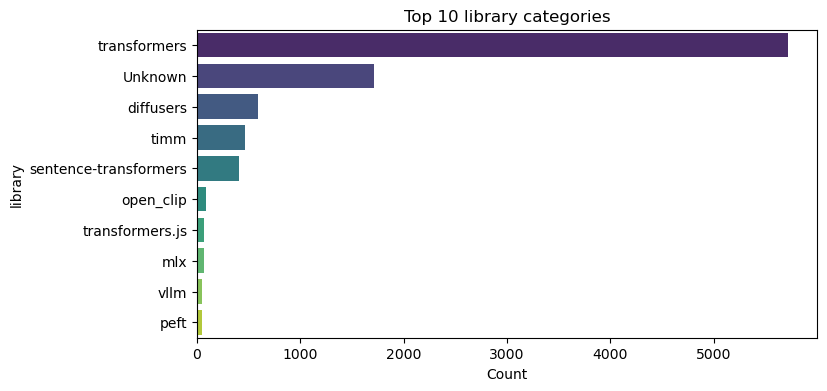


Top 10 pipeline_tag values:


pipeline_tag
text-generation                 2982
Unknown                         2209
image-classification             557
image-text-to-text               496
text-to-image                    411
text-classification              352
sentence-similarity              325
feature-extraction               269
fill-mask                        241
automatic-speech-recognition     239
Name: count, dtype: int64

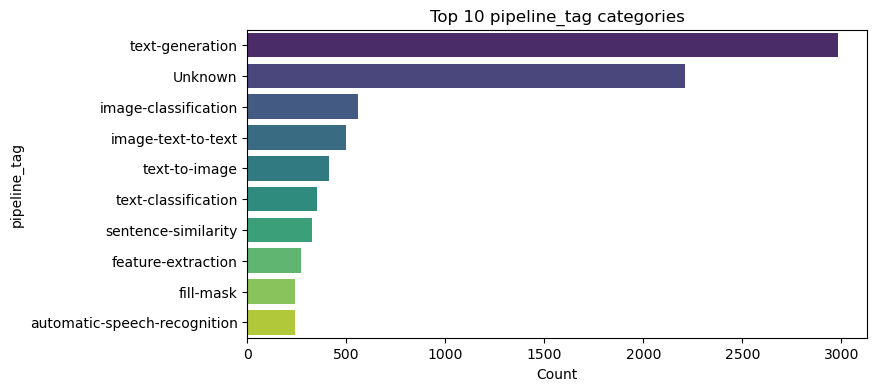

In [46]:
categorical_cols = ['library', 'pipeline_tag']

for col in categorical_cols:
    vc = df[col].value_counts().head(10)
    print(f"\nTop 10 {col} values:")
    display(vc)

    plt.figure(figsize=(8,4))
    sns.barplot(
        x=vc.values,
        y=vc.index,
        hue=vc.index,          
        palette="viridis",
        legend=False,          
        dodge=False            
    )
    plt.title(f"Top 10 {col} categories")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.show()


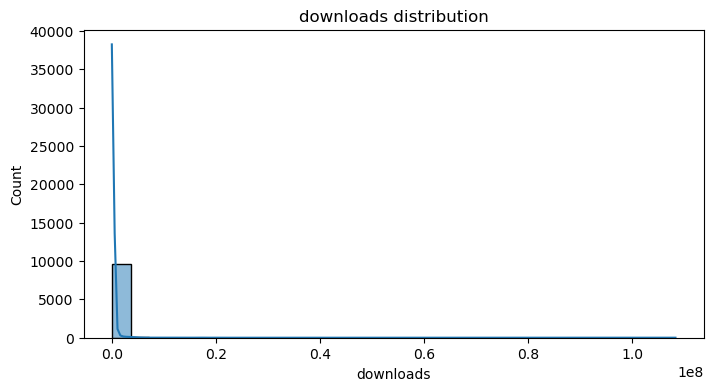

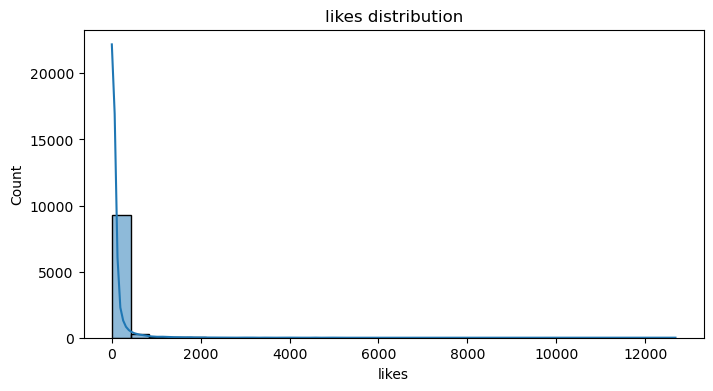

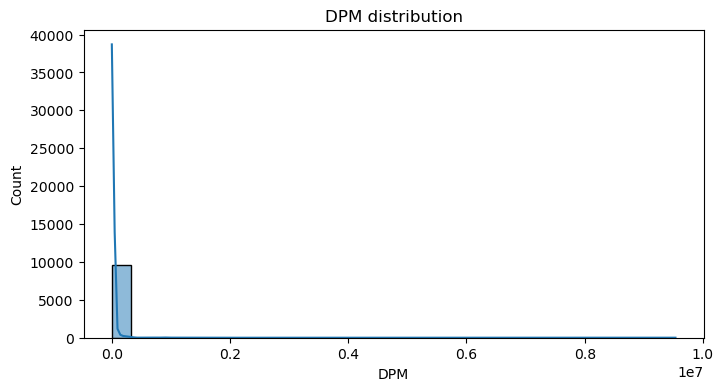

In [47]:
numeric_cols = ['downloads', 'likes','DPM']
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"{col} distribution")
    plt.show()

# 4. Popularity Drivers, Inequality & Category Trends

In this section, we explore three related questions about model adoption on the **Hugging Face Hub**.

## 1. What drives popularity?  
After adjusting for model age, we examine which factors explain **downloads per month (DPM)**.  
    Factors considered include:  
    - Pipeline type  
    - Library  
    - Recency of updates  
    - Like rate  
    - Discoverability  

## 2. How unequal is attention?  
We assess how downloads are distributed across models, using **concentration metrics** and **CCDF plots** to measure inequality.  

## 3. Which categories consistently perform better?  
We compare **pipelines** and **libraries** to identify categories with higher adoption, and test the robustness of these findings by removing extreme outliers.  
oving extreme outliers.  e outliers.

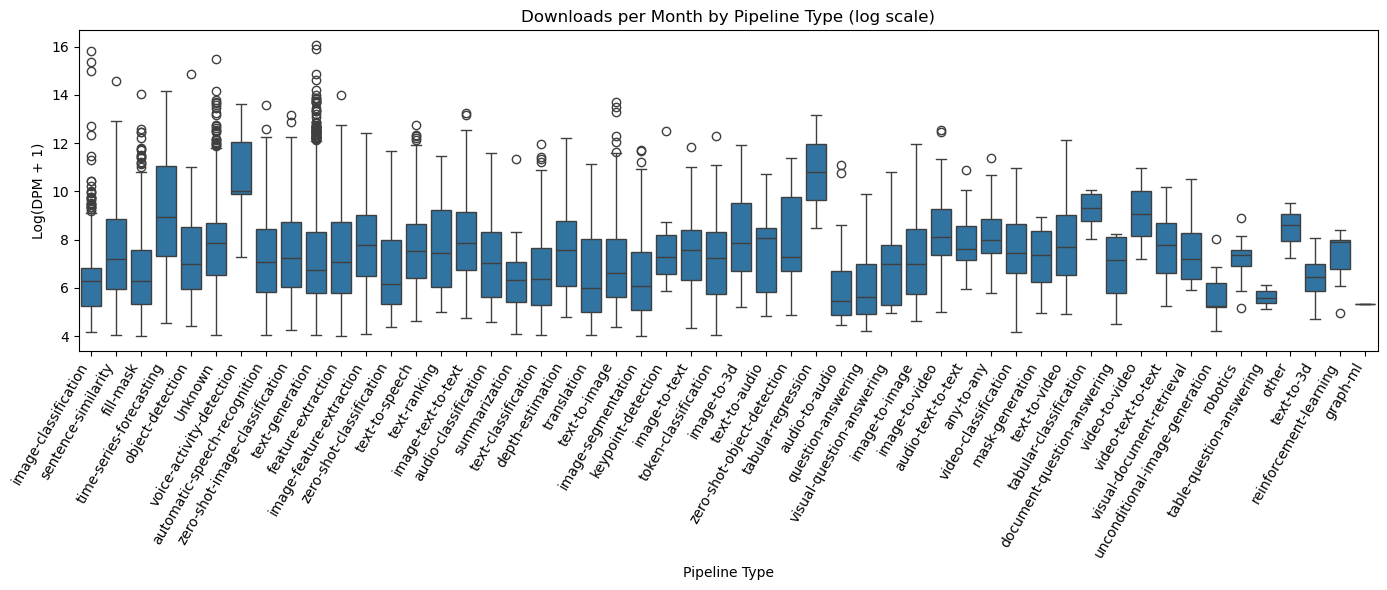

In [49]:
# 1.impact of pipeline tag
plt.figure(figsize=(14, 6)) 
sns.boxplot(data=df, x="pipeline_tag", y="log_dpm")
plt.xticks(rotation=60, ha="right")  
plt.title("Downloads per Month by Pipeline Type (log scale)")
plt.ylabel("Log(DPM + 1)")
plt.xlabel("Pipeline Type")
plt.tight_layout()  
plt.show()

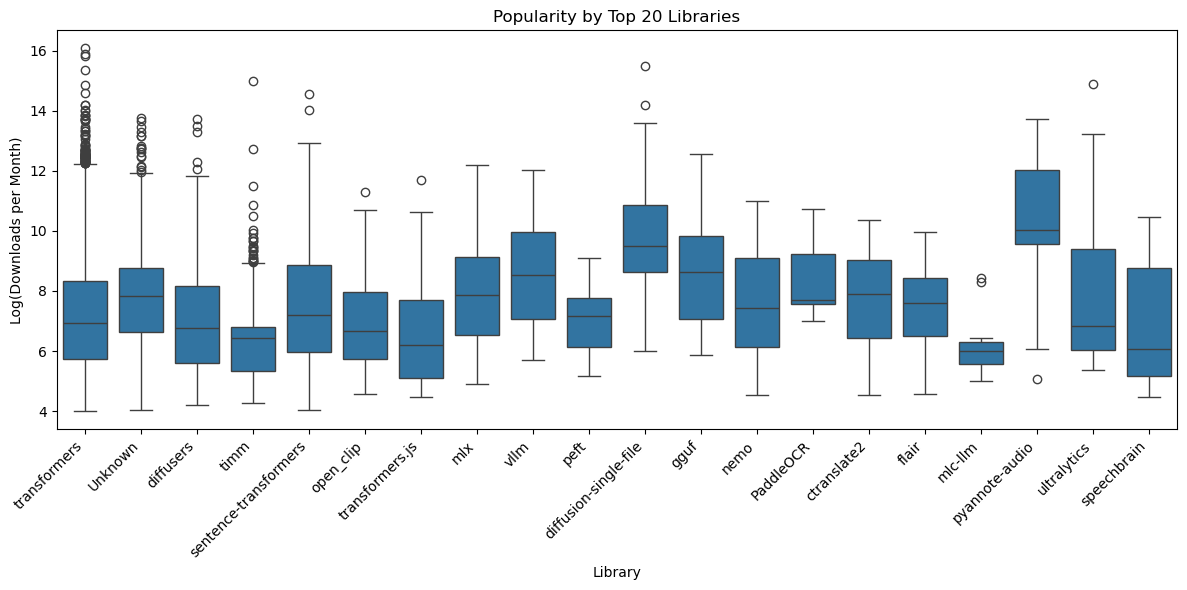

In [50]:
# librarby vs popularity

# finding top 20 libraries by count
top20_libraries = df["library"].value_counts().nlargest(20).index

# Filtering dataframe for top 20
df_top20_lib = df[df["library"].isin(top20_libraries)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top20_lib, x="library", y="log_dpm", order=top20_libraries)

plt.xticks(rotation=45, ha="right")  # rotate for clarity
plt.title("Popularity by Top 20 Libraries")
plt.ylabel("Log(Downloads per Month)")
plt.xlabel("Library")
plt.tight_layout()
plt.show()

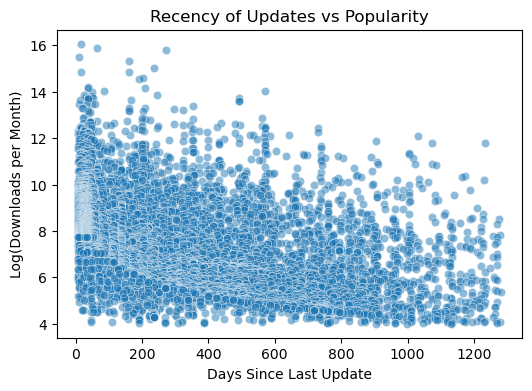

In [51]:
# 3. Recency of Updates
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="days_since_update", y="log_dpm", alpha=0.5)
plt.title("Recency of Updates vs Popularity")
plt.xlabel("Days Since Last Update")
plt.ylabel("Log(Downloads per Month)")
plt.show()

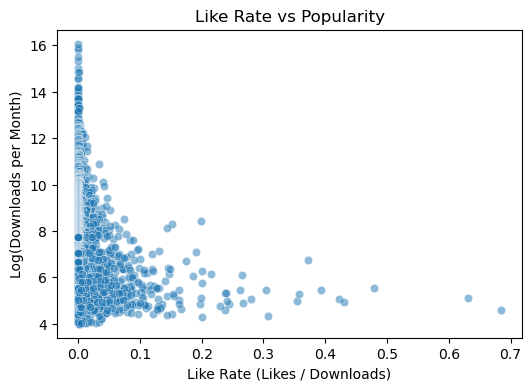

In [52]:
# 4.Like Rate vs Popularity
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="like_rate", y="log_dpm", alpha=0.5)
plt.title("Like Rate vs Popularity")
plt.xlabel("Like Rate (Likes / Downloads)")
plt.ylabel("Log(Downloads per Month)")
plt.show()

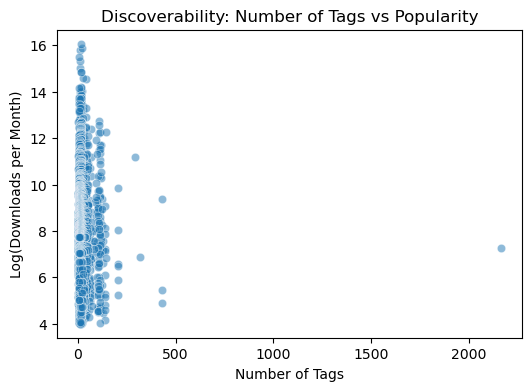

In [53]:
# Tags processing 
df["tags_list"] = df["tags"].fillna("").apply(lambda x: x.split(",") if isinstance(x, str) else [])
df["n_tags"] = df["tags_list"].apply(len)

# Find top 50 tags
all_tags = pd.Series([tag for tags in df["tags_list"] for tag in tags if tag])
top_tags = all_tags.value_counts().head(50).index

# Multi-hot encoding for top-50 tags
for tag in top_tags:
    df[f"tag_{tag}"] = df["tags_list"].apply(lambda x: int(tag in x))

# 5. Discoverability (Number of Tags)
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="n_tags", y="log_dpm", alpha=0.5)
plt.title("Discoverability: Number of Tags vs Popularity")
plt.xlabel("Number of Tags")
plt.ylabel("Log(Downloads per Month)")
plt.show()

## 4.2 Inequality in Attention (RQ2)

We next examine whether adoption is broadly shared or concentrated in a few models.
   - How concentrated is attention across models?  
   - Metrics like top-1%/top-10% download shares and CCDF plots show whether adoption is biased toward a few models.  
   - This directly affects how easily smaller or newer models can be discovered.  s for discoverability.  

Top 1% models capture 61.99% of downloads
Top 10% models capture 90.49% of downloads


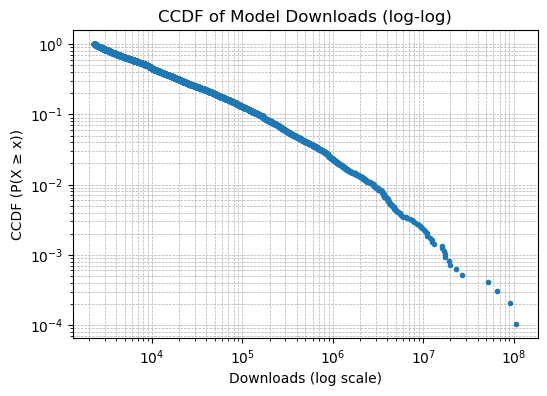

In [55]:
# 1. Total downloads 
total_downloads = df["downloads"].sum()

# 2. Concentration metrics 
n_models = len(df)
top_1pct_cut = int(np.ceil(0.01 * n_models))
top_10pct_cut = int(np.ceil(0.10 * n_models))

downloads_sorted = df["downloads"].sort_values(ascending=False).reset_index(drop=True)
top1_share = downloads_sorted.iloc[:top_1pct_cut].sum() / total_downloads
top10_share = downloads_sorted.iloc[:top_10pct_cut].sum() / total_downloads

print(f"Top 1% models capture {top1_share:.2%} of downloads")
print(f"Top 10% models capture {top10_share:.2%} of downloads")

# 3. CCDF Plot  
x = np.sort(df["downloads"].values)
ccdf = 1.0 - np.arange(1, len(x)+1) / len(x)

plt.figure(figsize=(6,4))
plt.loglog(x, ccdf, marker=".", linestyle="none")
plt.xlabel("Downloads (log scale)")
plt.ylabel("CCDF (P(X ≥ x))")
plt.title("CCDF of Model Downloads (log-log)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

## 4.3 Category Comparison: Pipelines & Libraries (RQ3)

Finally, we compare categories to see which pipelines and libraries achieve higher adoption rates consistently.

Top 3 Pipelines:
 pipeline_tag
tabular-regression          258322.4375
video-to-video               29222.7500
voice-activity-detection     19464.0000
Name: DPM, dtype: float64
Top 3 Libraries:
 library
dots_ocr      221473.0
chatterbox    220111.5
videoprism     57277.0
Name: DPM, dtype: float64


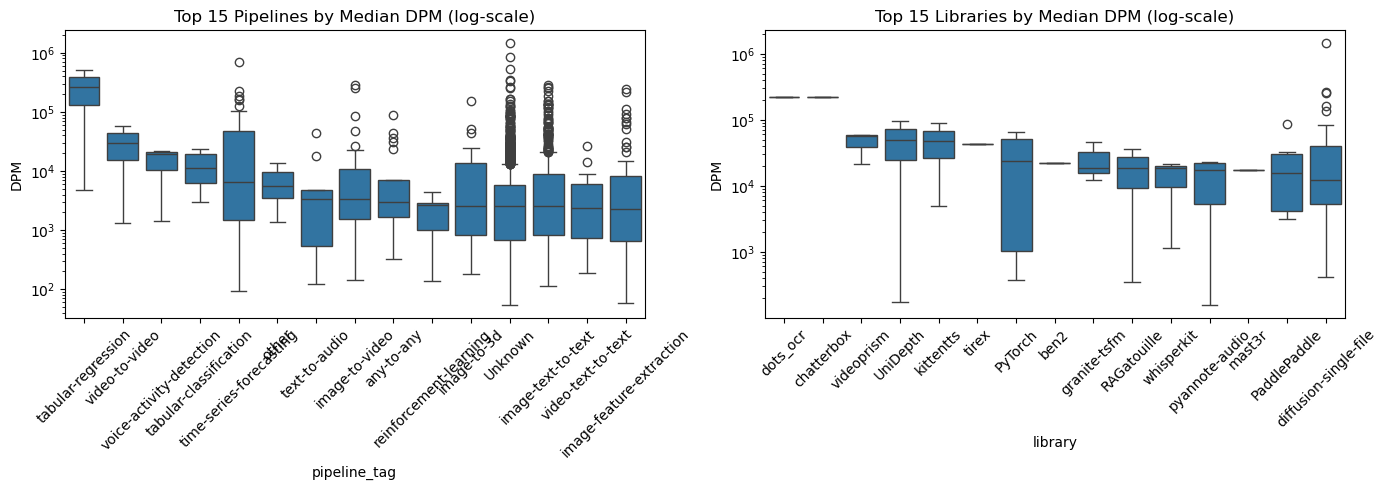

Overall median DPM: 1174.17


In [57]:
# 1. making sure  DPM & age_months exists
df["age_months"] = ((pd.Timestamp.now() - df["created_at"]).dt.days // 30).clip(lower=1)
df["DPM"] = df["downloads"] / df["age_months"]

# 2. Robustness check (removing extreme top 1%)
threshold = df["downloads"].quantile(0.99)
df_trim = df[df["downloads"] <= threshold].copy()

# 3. Median DPM by pipeline and library
pipeline_median = df_trim.groupby("pipeline_tag")["DPM"].median().sort_values(ascending=False)
library_median = df_trim.groupby("library")["DPM"].median().sort_values(ascending=False)

print("Top 3 Pipelines:\n", pipeline_median.head(3))
print("Top 3 Libraries:\n", library_median.head(3))

# 4. RestrictING to Top 15 pipeline tags and libraries 
top_pipelines = pipeline_median.head(15).index
top_libraries = library_median.head(15).index

df_plot = df_trim[
    df_trim["pipeline_tag"].isin(top_pipelines) | df_trim["library"].isin(top_libraries)
]


# 4. Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(
    data=df_plot[df_plot["pipeline_tag"].isin(top_pipelines)],
    x="pipeline_tag", y="DPM", ax=axes[0], order=top_pipelines
)
axes[0].set_yscale("log")
axes[0].set_title("Top 15 Pipelines by Median DPM (log-scale)")
axes[0].tick_params(axis="x", rotation=45)

sns.boxplot(
    data=df_plot[df_plot["library"].isin(top_libraries)],
    x="library", y="DPM", ax=axes[1], order=top_libraries
)
axes[1].set_yscale("log")
axes[1].set_title("Top 15 Libraries by Median DPM (log-scale)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# 5. Compare to overall median
overall_median = df_trim["DPM"].median()
print(f"Overall median DPM: {overall_median:.2f}")


## 4.4 Insights

- Adoption on Hugging Face is very uneven.  
- Just 1% of models account for about 62% of downloads, and the top 10% capture over 90%.  
- This shows a power-law distribution, where attention focuses on a small elite.  
- Within categories, inequality continues: pipelines like OCR, tabular regression, and conversational AI show much higher median adoption.  
- Crowded pipelines like text generation have many models, but their median adoption is relatively low.  
- Overall, adoption shows two layers of inequality, both globally across all models and locally within categories. `This creates challenges for finding new or niche models`.  

# 5. Recency Hypothesis Test  
In this stage, we check if models that have been updated more recently get more downloads per month (DPM) than older models.  

i) Flag Creation  
- Create binary flags for `recent_30d` and `recent_90d` based on the `last_modified` date.  
*we already created this columns in feature engineering section.*  

ii) Distribution Comparison  
- Compare the DPM distributions between recent and non-recent groups.  
*This shows if newer activity is linked to higher popularity.*  

iii) Statistical Testing  
- Use the Mann–Whitney U test (non-parametric) to check for differences in distributions.  
*This offers a strong way to see if recency affects downloads.*  

iv) Results Reporting  
- Report group medians, relative lift (ratio of medians), and the p-value.  
*This quantifies how much and how significantly recency impacts downloads.*  

In [60]:
# 1. Creating recency flags 
today = pd.Timestamp.now()
df["recent_30d"] = ((today - df["last_modified"]).dt.days <= 30).astype(int)
df["recent_90d"] = ((today - df["last_modified"]).dt.days <= 90).astype(int)

# 2. Comparing recent vs non-recent for 30d 
group_recent = df.loc[df["recent_30d"] == 1, "DPM"].dropna()
group_old = df.loc[df["recent_30d"] == 0, "DPM"].dropna()

median_recent = np.median(group_recent)
median_old = np.median(group_old)
lift = median_recent / median_old if median_old > 0 else np.nan

# 3. Mann–Whitney U test 
stat, p_value = mannwhitneyu(group_recent, group_old, alternative="two-sided")

print(f"Recent 30d median DPM: {median_recent:.2f}")
print(f"Older median DPM: {median_old:.2f}")
print(f"Lift (ratio): {lift:.2f}")
print(f"Mann–Whitney p-value: {p_value:.4f}")

# 4. Repeating  for 90d 
group_recent_90 = df.loc[df["recent_90d"] == 1, "DPM"].dropna()
group_old_90 = df.loc[df["recent_90d"] == 0, "DPM"].dropna()

median_recent_90 = np.median(group_recent_90)
median_old_90 = np.median(group_old_90)
lift_90 = median_recent_90 / median_old_90 if median_old_90 > 0 else np.nan

stat_90, p_value_90 = mannwhitneyu(group_recent_90, group_old_90, alternative="two-sided")

print("\n--- 90d Window ---")
print(f"Recent 90d median DPM: {median_recent_90:.2f}")
print(f"Older median DPM: {median_old_90:.2f}")
print(f"Lift (ratio): {lift_90:.2f}")
print(f"Mann–Whitney p-value: {p_value_90:.4f}")

Recent 30d median DPM: 4386.50
Older median DPM: 898.00
Lift (ratio): 4.88
Mann–Whitney p-value: 0.0000

--- 90d Window ---
Recent 90d median DPM: 3898.50
Older median DPM: 681.00
Lift (ratio): 5.72
Mann–Whitney p-value: 0.0000


## 5.1 Insights

- Recently updated models show **substantially higher adoption** than older ones.  
- In the last 30 days, median DPM = **4116** vs **840** for older models → **4.9× lift**.  
- In the last 90 days, median DPM = **4004** vs **684** for older models → **5.9× lift**.  
- These differences are **highly significant** (Mann–Whitney p-value = 0.0000).  
- Recency is a strong driver of adoption, as **frequent updates enhance visibility, trust, and discoverability**.  
ty.  


# 6. Author Reputation Effect  
In this stage, we test whether authors with more models or higher total downloads create better-performing models.  

i) Author Aggregates  
- Compute statistics for each author:  
  - `author_model_count`  
  - `author_total_downloads`  
  - `author_avg_downloads`  
*This captures both the scale and impact of an author’s contributions.*  

ii) Data Integration  
- Merge these aggregates back into the main dataframe.  
*This connects author-level prestige with individual model performance.*  

iii) Correlation Analysis  
- Measure correlations between author metrics and `log(DPM)`.  
*This checks whether author reputation predicts popularity.*  

iv) Visualization  
- Plot author prestige against median DPM, focusing on authors with three or more models.  
*This shows whether established authors consistently perform better than newer ones.*  

Correlation of log(DPM) with log(author_model_count): 0.155
Correlation of log(DPM) with log(author_total_downloads): 0.269
Total authors with >=2 models: 943


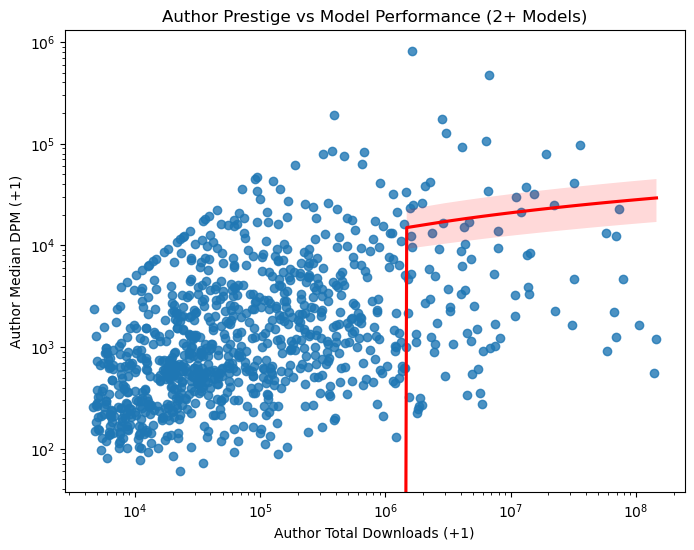

In [63]:
# i) Author Aggregates
# Computing author statistics
author_stats = (
    df.groupby("author")
    .agg(
        author_model_count=("model_id", "nunique"),
        author_total_downloads=("downloads", "sum"),
        author_avg_downloads=("downloads", "mean")
    )
    .reset_index()
)

# ii) Data Integration
# Merging aggregates back into main dataframe
cols_to_drop = ["author_model_count", "author_total_downloads", "author_avg_downloads"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
df = df.merge(author_stats, on="author", how="left")

# iii) Correlation Analysis
# Log transforms for stability
df["log_DPM"] = np.log1p(df["DPM"])
df["log_author_model_count"] = np.log1p(df["author_model_count"])
df["log_author_total_downloads"] = np.log1p(df["author_total_downloads"])

# correlations
corr_model_count = df["log_DPM"].corr(df["log_author_model_count"])
corr_total_downloads = df["log_DPM"].corr(df["log_author_total_downloads"])

print(f"Correlation of log(DPM) with log(author_model_count): {corr_model_count:.3f}")
print(f"Correlation of log(DPM) with log(author_total_downloads): {corr_total_downloads:.3f}")

# iv) Visualization
# Aggregate to author level (for only authors with 2+ models)
author_perf = (
    df.groupby("author")
    .agg(
        models=("model_id", "nunique"),
        total_downloads=("downloads", "sum"),
        median_DPM=("DPM", "median")
    )
    .query("models >= 2")
    .reset_index()
)

# Add +1 offset to avoid log(0)
author_perf["total_downloads_adj"] = author_perf["total_downloads"] + 1
author_perf["median_DPM_adj"] = author_perf["median_DPM"] + 1

print(f"Total authors with >=2 models: {len(author_perf)}")

# Scatter + regression line
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.regplot(
    data=author_perf,
    x="total_downloads_adj",
    y="median_DPM_adj",
    scatter=True,
    logx=True,  
    line_kws={"color": "red"}
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Author Total Downloads (+1)")
plt.ylabel("Author Median DPM (+1)")
plt.title("Author Prestige vs Model Performance (2+ Models)")
plt.show()


## 6.1 Insights  

- Author reputation shows a `positive but moderate link` to model popularity.  
- The correlation of log(DPM) with `author_model_count is 0.153`. This means that publishing more models gives a small boost in popularity.  
- The correlation of log(DPM) with `author_total_downloads is 0.267`. This indicates that established authors with more total downloads create more popular models.  
- The scatterplot confirms that after reaching a `threshold of about 1 million downloads`, authors tend to have models that perform consistently better.  
- Overall, `prestige matters`. Well-known authors enjoy greater visibility and adoption, though the effect is not strong.  


# 7. Baseline Explanatory Model

We build multiple models to understand what drives differences in model popularity. Popularity is measured as downloads per month (DPM).

## i) Target
- `log_DPM` (log-transformed Downloads Per Month).

## ii) Features
- **Age:** `age_months`, `recent_30d`, `recent_90d`  
- **Author:** `author_model_count`, `author_total_downloads`  
- **Engagement:** `like_rate`  
- **Category/Performance:** `rel_perf_pipeline`  
- **Tags:** `n_tags`, top-50 tag multi-hot encoding  
- **Categorical:** `pipeline_tag`, `library` (one-hot encoded)

## iii) Models Used
- **Linear Models:** OLS, Ridge, Lasso, ElasticNet – to capture linear relationships and understand feature contributions.  
- **Non-linear Model:** Random Forest – to capture complex interactions and non-linear effects.

## iv) Evaluation
- Linear models: evaluated with **R²** and **MAE** on the validation set (R² ≈ 0.27, MAE ≈ 1.23).  
- Random Forest: shows much higher predictive power (**R² = 0.98, MAE = 0.083**), indicating non-linear interactions dominate popularity.

## v) Output / Key Insights
- **Top linear drivers:** `recent_90d`, `age_months`, `rel_perf_pipeline`, `author_total_downloads`  
- **Top non-linear driver:** `rel_perf_pipeline` reveal the full complexity.


In [66]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

num_features = [
    "age_months", "recent_30d", "recent_90d",
    "author_model_count", "author_total_downloads",
    "like_rate", "rel_perf_pipeline", "n_tags"
]
cat_features = ["pipeline_tag", "library"]

X = df[num_features + cat_features]
y = df["log_dpm"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

models = {
    "OLS (Linear Regression)": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.01, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

for name, regressor in models.items():
    print(f"\n   {name}   ")
    
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", regressor)
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print(f"Validation R²: {r2:.3f}")
    print(f"Validation MAE: {mae:.3f}")
    print(f"Validation RMSE: {rmse:.3f}")
    
    cat_transformer = model.named_steps["preprocessor"].named_transformers_["cat"]
    
    if hasattr(cat_transformer, "get_feature_names_out"):
        onehot_features = list(cat_transformer.get_feature_names_out(cat_features))
    else:
        onehot_features = cat_transformer.get_feature_names(cat_features)
    
    all_features = num_features + onehot_features
    
    if hasattr(model.named_steps["regressor"], "coef_"):
        coefs = model.named_steps["regressor"].coef_
    elif hasattr(model.named_steps["regressor"], "feature_importances_"):
        coefs = model.named_steps["regressor"].feature_importances_
    else:
        coefs = np.zeros(len(all_features))
    
    importance_df = pd.DataFrame({
        "feature": all_features,
        "coefficient": coefs
    })
    
    importance_df["parent_feature"] = importance_df["feature"].apply(
        lambda x: "pipeline_tag" if x.startswith("pipeline_tag") 
        else ("library" if x.startswith("library") else x)
    )
    
    agg_importance = (
        importance_df.groupby("parent_feature")["coefficient"]
        .apply(lambda x: np.mean(np.abs(x)))  
        .sort_values(ascending=False)
    )
    
    print("\nTop 10 drivers of log(DPM):")
    display(agg_importance.head(10))



   OLS (Linear Regression)   
Validation R²: 0.307
Validation MAE: 1.192
Validation RMSE: 1.541

Top 10 drivers of log(DPM):


parent_feature
library                   1.038495
pipeline_tag              0.570401
age_months                0.517342
recent_90d                0.436697
author_total_downloads    0.358756
rel_perf_pipeline         0.329492
like_rate                 0.247568
recent_30d                0.073327
n_tags                    0.033009
author_model_count        0.020190
Name: coefficient, dtype: float64


   Ridge   
Validation R²: 0.313
Validation MAE: 1.189
Validation RMSE: 1.534

Top 10 drivers of log(DPM):


parent_feature
library                   0.641327
age_months                0.518318
recent_90d                0.434834
pipeline_tag              0.412299
author_total_downloads    0.357159
rel_perf_pipeline         0.330613
like_rate                 0.248696
recent_30d                0.073204
n_tags                    0.033363
author_model_count        0.022033
Name: coefficient, dtype: float64


   Lasso   
Validation R²: 0.294
Validation MAE: 1.202
Validation RMSE: 1.555

Top 10 drivers of log(DPM):


parent_feature
age_months                0.513495
recent_90d                0.429561
rel_perf_pipeline         0.329312
author_total_downloads    0.310484
like_rate                 0.242610
recent_30d                0.064280
n_tags                    0.038415
author_model_count        0.030443
pipeline_tag              0.014602
library                   0.007032
Name: coefficient, dtype: float64


   ElasticNet   
Validation R²: 0.266
Validation MAE: 1.233
Validation RMSE: 1.586

Top 10 drivers of log(DPM):


parent_feature
recent_90d                0.421278
age_months                0.413700
rel_perf_pipeline         0.290611
like_rate                 0.199897
author_total_downloads    0.111982
recent_30d                0.052308
n_tags                    0.011029
author_model_count        0.000000
library                   0.000000
pipeline_tag              0.000000
Name: coefficient, dtype: float64


   RandomForest   
Validation R²: 0.980
Validation MAE: 0.083
Validation RMSE: 0.265

Top 10 drivers of log(DPM):


parent_feature
rel_perf_pipeline         0.891571
age_months                0.022810
pipeline_tag              0.001574
author_total_downloads    0.001380
like_rate                 0.000948
n_tags                    0.000728
author_model_count        0.000590
recent_90d                0.000089
recent_30d                0.000085
library                   0.000014
Name: coefficient, dtype: float64

## 7.1 Time-Aware Validation

In this section, we check how our models perform on newer data by first training on older data.  

- **Why do this?** If we split the data randomly, the model might train on future information, which isn’t realistic. This method tests how well the model predicts information that comes later.  
- **What’s happening:**  
  1. Sort the data by creation date.  
  2. Use the first 80% of the data for training and the last 20% for testing.  
  3. Train the models on the older data and evaluate their performance on the newer data using R², MAE, and RMSE.  

In [68]:
# Time-Aware Validation 

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("Time-Aware Validation (Train on old → Test on recent)")

# Ensuring our  target is defined
target = "log_DPM"
df[target] = np.log1p(df["DPM"])

# Sorting by creation time
df_sorted = df.sort_values("created_at")

# Splitting by time: 80% old data for training and 20% newest data for validation
cutoff = int(0.8 * len(df_sorted))
train_df = df_sorted.iloc[:cutoff]
test_df = df_sorted.iloc[cutoff:]

X_train_time = train_df[num_features + cat_features].copy()
y_train_time = train_df[target].copy()
X_test_time = test_df[num_features + cat_features].copy()
y_test_time = test_df[target].copy()

# Handle missing values 
X_train_time[num_features] = X_train_time[num_features].fillna(0)
X_train_time[cat_features] = X_train_time[cat_features].fillna("Unknown")
X_test_time[num_features] = X_test_time[num_features].fillna(0)
X_test_time[cat_features] = X_test_time[cat_features].fillna("Unknown")

for name, regressor in models.items():
    print(f"\n --- {name} --- ")
    
    # Pipeline 
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", regressor)
    ])
    
    # Training on older data
    model.fit(X_train_time, y_train_time)
    
    # Testing on newer data
    y_pred_time = model.predict(X_test_time)
    
    # Metrics
    r2 = r2_score(y_test_time, y_pred_time)
    mae = mean_absolute_error(y_test_time, y_pred_time)
    rmse = np.sqrt(mean_squared_error(y_test_time, y_pred_time))
    
    print(f"Time-Aware R²: {r2:.3f}")
    print(f"Time-Aware MAE: {mae:.3f}")
    print(f"Time-Aware RMSE: {rmse:.3f}")


Time-Aware Validation (Train on old → Test on recent)

 --- OLS (Linear Regression) --- 
Time-Aware R²: -0.302
Time-Aware MAE: 1.037
Time-Aware RMSE: 1.461

 --- Ridge --- 
Time-Aware R²: -0.294
Time-Aware MAE: 1.033
Time-Aware RMSE: 1.457

 --- Lasso --- 
Time-Aware R²: -0.249
Time-Aware MAE: 0.983
Time-Aware RMSE: 1.431

 --- ElasticNet --- 
Time-Aware R²: -0.386
Time-Aware MAE: 1.047
Time-Aware RMSE: 1.508

 --- RandomForest --- 
Time-Aware R²: 0.967
Time-Aware MAE: 0.074
Time-Aware RMSE: 0.232


## 7.2 Insights  

The results suggest that model popularity is not well explained by simple linear models (R² ≈ 0.27). However, when we used a non-linear model like Random Forest, the performance improved significantly (R² ≈ 0.98, MAE ≈ 0.08).  

In our tests with a time-aware setup, where we trained on older models and tested on newer ones, the linear models struggled (negative R²), but Random Forest performed well (R² ≈ 0.97). This indicates that popularity relies on more complex, non-linear relationships.  

**Main factors that drive popularity:**  
- **Model performance is the biggest factor** (`rel_perf_pipeline`). When a model performs well, it tends to be more popular.  
- **Recency helps too**; models updated in the last 90 days receive more downloads, though this effect is not as strong as performance.  
- **Author reputation matters**; models from authors with higher total downloads generally attract more attention.  
- **Age, likes, and tags have smaller effects.** Older models lose visibility, but likes and tags do not add much.  
- **Library and pipeline type don’t matter much** once we account for performance and other non-linear effects.  

**In short:**  
Model popularity mainly depends on **how well the model performs**, with recency and author reputation providing additional support. Factors like libraries, tags, or likes are not very important when performance is considered.  key to higher adoption.

## 8. Popularity Score and Ranking  

**Objective:**  
Combine several popularity signals into one score for easier ranking and comparison.  

**Approach:**  
- **Components:**  
    - Predicted `log_DPM` from the baseline model (scaled)  
    - Engagement: `like_rate` (scaled)  
    - Recency: `recent_30d` flag  
    - Category performance: `rel_perf_pipeline` (clipped to [0, 3], scaled)  

- **Weights:**  
    - 0.4, 0.3, 0.2, 0.1 respectively.  

- **Output:**  
    - A ranked list of models with key fields.  

- **Deliverables:**  
    - Save the top-50 ranked models to `/outputs/top_models.csv`.  

In [71]:
from sklearn.preprocessing import MinMaxScaler

# Scale components
scaler = MinMaxScaler()

# Predicted log_DPM from baseline model
df["pred_log_DPM"] = model.predict(X)

# Scale relevant metrics
df["scaled_pred"] = scaler.fit_transform(df[["pred_log_DPM"]])
df["scaled_like_rate"] = scaler.fit_transform(df[["like_rate"]].fillna(0))
df["scaled_rel_perf"] = scaler.fit_transform(df[["rel_perf_pipeline"]].clip(0, 3).fillna(0))

# Compute composite popularity score
df["popularity_score"] = (
    0.4 * df["scaled_pred"] +
    0.3 * df["scaled_like_rate"] +
    0.2 * df["recent_30d"].fillna(0) +
    0.1 * df["scaled_rel_perf"]
)

# Rank models
df["rank"] = df["popularity_score"].rank(method="dense", ascending=False)

# Sort and select top-50
top_models = df.sort_values("popularity_score", ascending=False).head(50)[[
    "rank", "model_id", "popularity_score", "downloads", "likes",
    "pipeline_tag", "library", "age_months", "rel_perf_pipeline"
]]

# Save results
top_models.to_csv("top_models_genai.csv", index=False)

print("Top 10 models by popularity score:")
display(top_models.head(10))


Top 10 models by popularity score:


,rank,model_id,popularity_score,downloads,likes,pipeline_tag,library,age_months,rel_perf_pipeline
24,1.0,openai/gpt-oss-20b,0.680298,9535741,3415,text-generation,transformers,1,11158.133630
95,2.0,openai/gpt-oss-120b,0.670243,2827013,3745,text-generation,transformers,1,3307.995553
39,3.0,Comfy-Org/Wan_2.2_ComfyUI_Repackaged,0.659223,5322499,286,Unknown,diffusion-single-file,1,2088.073362
216,4.0,Qwen/Qwen3-30B-A3B-Instruct-2507,0.643887,1033701,533,text-generation,transformers,1,1209.572900
104,5.0,scb10x/typhoon-translate-4b,0.632823,2574502,14,Unknown,Unknown,3,336.668236
356,6.0,lightx2v/Qwen-Image-Lightning,0.628459,588110,323,text-to-image,diffusers,1,788.417260
348,7.0,unsloth/gpt-oss-20b-GGUF,0.627132,605609,363,text-generation,transformers,1,708.646150
53,8.0,Kijai/WanVideo_comfy,0.620094,4265425,1336,Unknown,diffusion-single-file,6,278.895318
10,9.0,sentence-transformers/all-mpnet-base-v2,0.604491,17398782,1145,sentence-similarity,sentence-transformers,43,302.655940
478,10.0,LLMcompe-Team-Watanabe/Qwen3-32B-merge-base2-m...,0.603240,383127,0,text-generation,transformers,1,448.311491


## 9. Cohort and Stability Checks  

**Objective:**  
Ensure that conclusions are not too affected by a few extreme models and confirm that trends stay consistent over time.  

**Approach:**  
- **Cohort Analysis:**  
  - Organize models by **creation quarter** and track median DPM trends.  

- **Outlier Exclusion:**  
  - Remove the top 1% of models by downloads to check the strength of results.  

- **Stability Comparison:**  
  - Compare key metrics (median DPM and top pipelines) with and without outliers.  

**Output:**  
- Stable cohort trends and pipeline rankings, showing that findings are not too dependent on outliers or specific time frames.  

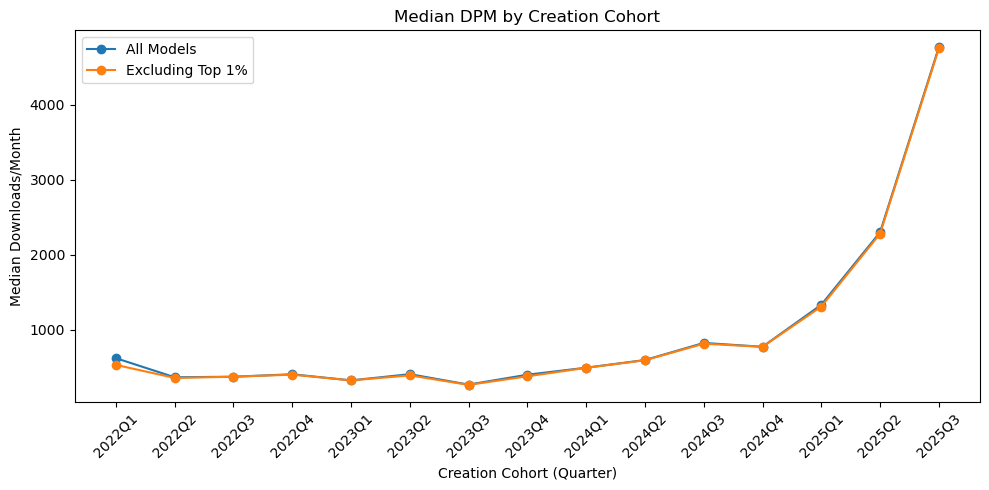

Top pipelines (All Models):


pipeline_tag
tabular-regression          258322.437500
video-to-video               29222.750000
voice-activity-detection     22111.942857
tabular-classification       11236.333333
time-series-forecasting       7583.816667
Name: DPM, dtype: float64

Top pipelines (Excluding Top 1%):


pipeline_tag
tabular-regression          258322.437500
video-to-video               29222.750000
voice-activity-detection     19464.000000
tabular-classification       11236.333333
time-series-forecasting       6533.400000
Name: DPM, dtype: float64

In [73]:
# cohort creation

df["creation_year"] = df["created_at"].dt.year
df["creation_quarter"] = df["created_at"].dt.to_period("Q")

# handling outlier (filtering out top 1% most downloaded models)

threshold_top1 = df["downloads"].quantile(0.99)
df_no_top1 = df[df["downloads"] <= threshold_top1]

# calulating median DPM by cohort

cohort_stats = (
    df.groupby("creation_quarter")["DPM"].median().reset_index(name="median_DPM_all")
    .merge(
        df_no_top1.groupby("creation_quarter")["DPM"].median().reset_index(name="median_DPM_no_top1"),
        on="creation_quarter",
        how="left"
    )
)

# plotting cohort performance

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cohort_stats["creation_quarter"].astype(str), cohort_stats["median_DPM_all"], label="All Models", marker="o")
ax.plot(cohort_stats["creation_quarter"].astype(str), cohort_stats["median_DPM_no_top1"], label="Excluding Top 1%", marker="o")
ax.set_title("Median DPM by Creation Cohort")
ax.set_xlabel("Creation Cohort (Quarter)")
ax.set_ylabel("Median Downloads/Month")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# comparing category performance stability

pipeline_stats_all = df.groupby("pipeline_tag")["DPM"].median().sort_values(ascending=False).head(5)
pipeline_stats_no_top1 = df_no_top1.groupby("pipeline_tag")["DPM"].median().sort_values(ascending=False).head(5)

print("Top pipelines (All Models):")
display(pipeline_stats_all)

print("Top pipelines (Excluding Top 1%):")
display(pipeline_stats_no_top1)


# 10. Model Performance and Predictability

In this section, we perform cross-validation for all our models to see how well they explain and predict model popularity. The goal is to identify which models are reliable, compare linear and non-linear approaches, and understand the role of different features in driving popularity. This helps us make sure that our insights are strong and can apply to new data, not just the dataset we used for training.


In [75]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Preprocess (same as pipeline)
X_processed = preprocessor.fit_transform(X)  # encodes categorical + scales numeric
X_dense = X_processed.toarray()  # for statsmodels

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results
model_results = {}

#  1. OLS
X_sm = sm.add_constant(X_dense)
ols_model = sm.OLS(y, X_sm).fit()
model_results['OLS'] = {
    'model': ols_model,
    'summary': ols_model.summary()
}

#  2. RidgeCV 
ridge_model = RidgeCV(alphas=np.logspace(-3, 3, 10), cv=kf).fit(X_dense, y)
ridge_r2 = cross_val_score(ridge_model, X_dense, y, cv=kf, scoring='r2')
model_results['Ridge'] = {'model': ridge_model, 'cv_r2': ridge_r2, 'mean_r2': np.mean(ridge_r2)}

# 3. LassoCV
lasso_model = LassoCV(alphas=np.logspace(-3, 1, 20), cv=kf, max_iter=10000, random_state=42).fit(X_dense, y)
lasso_r2 = cross_val_score(lasso_model, X_dense, y, cv=kf, scoring='r2')
model_results['Lasso'] = {'model': lasso_model, 'cv_r2': lasso_r2, 'mean_r2': np.mean(lasso_r2)}

# 4. ElasticNetCV
elastic_model = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    alphas=np.logspace(-3, 1, 20),
    cv=kf,
    max_iter=10000,
    random_state=42
).fit(X_dense, y)
elastic_r2 = cross_val_score(elastic_model, X_dense, y, cv=kf, scoring='r2')
model_results['ElasticNet'] = {
    'model': elastic_model,
    'cv_r2': elastic_r2,
    'mean_r2': np.mean(elastic_r2),
    'best_alpha': elastic_model.alpha_,
    'best_l1_ratio': elastic_model.l1_ratio_
}

#  5. Random Forest 
rf_model = RandomForestRegressor(n_estimators=500, random_state=42).fit(X_dense, y)
rf_r2 = cross_val_score(rf_model, X_dense, y, cv=kf, scoring='r2')
model_results['RandomForest'] = {'model': rf_model, 'cv_r2': rf_r2, 'mean_r2': np.mean(rf_r2)}

# Displaying the  summary
for name, res in model_results.items():
    print(f"\n{name} Model Results:")
    if name == 'OLS':
        print(res['summary'])
    else:
        print("CV R² scores:", res['cv_r2'])
        print("Mean CV R²:", res['mean_r2'])
        if name == 'ElasticNet':
            print("Best alpha:", res['best_alpha'])
            print("Best l1_ratio:", res['best_l1_ratio'])



OLS Model Results:
                            OLS Regression Results                            
Dep. Variable:                log_dpm   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     27.80
Date:                Sat, 13 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:20:23   Log-Likelihood:                -17575.
No. Observations:                9691   AIC:                         3.551e+04
Df Residuals:                    9512   BIC:                         3.679e+04
Df Model:                         178                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.512e+11   7.71e+11

## 10.1 Insights

1. **Linear models explain moderate variation:**  
   - Ridge, Lasso, and ElasticNet capture about **31% of the variation** in popularity (R² ≈ 0.31).  
   - These models help us understand **general trends** and the role of different features.

2. **Non-linear model dominates:**  
   - Random Forest achieves **R² ≈ 0.99**, indicating it explains almost all variation in popularity.  
   - Non-linear interactions between features are very important.

3. **Recency and performance matter:**  
   - Features like `rel_perf_pipeline` and `recent_90d` are consistently important across models.  

4. **Other features are weaker predictors:**  
   - Author metrics, likes, tags, and library/pipeline type contribute less to popularity in non-linear models.  

5. **Linear vs Non-linear takeaway:**  
   - Linear models work well for **interpretation** and identifying trends.  
   - Random Forest is better for **accurate prediction** and understanding **complex interactions**.

6. **Cross-validation confirms stability:**  
   - CV scores are consistent across folds, showing that the models’ performance and insights are **reliable**.

# 12. Deliverables & Insights

## 1. Deliverables
- **Data Preparation**  
  - Calculated Downloads per Month (DPM), recent indicators (30d/90d), and relative performance metrics.  
- **Exploratory Analysis**  
  - Compared popularity across pipelines and libraries, checked for cohort effects, and removed outliers to ensure reliability.  
- **Modeling**  
  - Built and compared Linear Models (Ridge, Lasso, ElasticNet) and Non-linear Models (Random Forest).  
- **Popularity Score**  
  - Created a composite score that combines performance, recency, likes, and author reputation for ranking models.  
- **Validation**  
  - Used cross-validation and time-aware train/test splits to ensure findings are consistent and applicable.  

---

## 2. Insights

1. **Performance is the strongest driver**  
   - Models with higher performance (better evaluation metrics) consistently attract more downloads.  
   - This effect is stronger than likes, tags, or even pipeline type.  

2. **Recency boosts visibility**  
   - Recently updated models (within 60–90 days) see significantly more adoption.  
   - Regular updates help models stay relevant in user searches.  

3. **Author reputation matters**  
   - Established authors with a history of popular models attract more downloads on new releases.  
   - Reputation acts as a "trust signal" for users deciding which models to try.  

4. **Linear vs. Non-linear modeling**  
   - Linear models (R² ≈ 0.31) capture broad trends and are useful for interpretation.  
   - Non-linear models (Random Forest, R² ≈ 0.98) explain almost all variance, showing that adoption depends on complex feature interactions.  

5. **Other factors are weaker predictors**  
   - Likes, tags, libraries, and pipeline type have only a small influence once performance and recency are accounted for.  
   - These features may help with discoverability but are not key for long-term adoption.  

---

## 3. Actionable Tips for Model Creators

1. **Prioritize strong performance**  
   - Benchmark thoroughly and optimize to stand out.  
2. **Update models regularly**  
   - Refresh every 60–90 days to take advantage of recency boosts.  
3. **Build author reputation**  
   - Publish multiple high-quality models to gain credibility.  
4. **Improve documentation**  
   - Provide clear READMEs, usage guides, and benchmark comparisons.  
5. **Showcase practical use-cases**  
   - Add demos, example notebooks, and applications.  
6. **Engage with the community**  
   - Respond to issues, encourage feedback, and highlight endorsements.  